# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
import os
import time
import torch

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.utils import data
from torch.backends import cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io
from sklearn import metrics

%matplotlib inline
cudnn.benchmark = True

## Casting para o dispositivo correto

Como usaremos processamento vetorial principalmente em GPUs para aprendizado profundo, primeiramente é possível verificar se há uma GPU disponível com o trecho de código abaixo, armazenando os tensores nos dispositivos apropriados.

In [2]:
# Verificando se temos GPU/CUDA
has_cuda = torch.cuda.is_available()
device = torch.device('cuda' if has_cuda else 'cpu')

print(device)

cuda


# Intro MLP

## Neurônios e a camada `nn.Linear`

A camada Linear do Pytorch ([nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)) é responsável por aplicar uma transformação linear no dado de entrada. Esta camada recebe como parâmetro a dimensão (número de *features*) da entrada e da saída (que na verdade, representa o número de neurônios dessa camada). Por padrão o bias já é incluído. **Um** perceptron pode ser facilmente representado como a seguir, desconsiderando a função de ativação:

```
linear = nn.Linear(in_dimension, 1)
```
Mas de uma forma geral, uma camada Linear com diversas *features* de entrada e diversas *features* de saída pode ser representada como:
```
nn.Linear(in_features, out_features)
```
![](./figs/nn_linear.png)

In [3]:
linear = nn.Linear(2, 1)
print(linear)

Linear(in_features=2, out_features=1, bias=True)


Como é possível ver no código abaixo, o Pytorch já inicia os pesos da camada aleatoriamente.

In [4]:
for name, param in linear.named_parameters():
    print(f'Parameter {name}:')
    print(f'  - {param.data}\n')

Parameter weight:
  - tensor([[-0.3939, -0.6143]])

Parameter bias:
  - tensor([0.2576])



O **forward** consiste em passar seu dado de entrada pela rede, gerando um resultado ao final. Considerando a camada linear instanciada anteriormente, o resultado do forward é o mesmo do somatório da multiplicação de seus pesos pelas respectivas entradas juntamente com o bias, ou seja:

$$f_w(x) = w_0 + w_1x_1 + w_2x_2 + \ldots + w_nx_n$$

No Pytorch, realizamos o **forward** chamando o objeto onde nossa rede/modelo está instanciada, conforme exemplo abaixo.

In [5]:
linear = nn.Linear(2, 1)
X = torch.tensor([2.0, 3.0])

print('Using Linear:', linear(X))
print('Manual:', torch.sum(X * linear.weight) + linear.bias)  # .weight e .bias permite acessarmos os pesos e bias deste modelo

Using Linear: tensor([1.1799], grad_fn=<ViewBackward0>)
Manual: tensor([1.1799], grad_fn=<AddBackward0>)


In [6]:
# Ao fazermos linear(X), estamos fazendo implicitamente uma chamada na função forward da Linear
print('Forward com chamada implícita:', linear(X))
print('Forward com chamada explícita:', linear.forward(X))

Forward com chamada implícita: tensor([1.1799], grad_fn=<ViewBackward0>)
Forward com chamada explícita: tensor([1.1799], grad_fn=<ViewBackward0>)


## Exemplo de uma rede neural simples (1 camada)

O código abaixo cria uma rede neural simples usando `nn.Linear` e implementa o fluxo de treinamento para essa rede, ou seja, faz o forward, calcula a loss, e otimiza seus pesos. Invista um pouco de tempo para entender a célula abaixo pois usaremos essa ideia para implementar a função de treino mais a frente.

In [7]:
# Iremos criar dados que seguem a função y = 2x + 3
dataset = []
for x in range(10):
    dataset.append((x, 2*x + 3))  # tupla com (x, y)

In [8]:
dataset

[(0, 3),
 (1, 5),
 (2, 7),
 (3, 9),
 (4, 11),
 (5, 13),
 (6, 15),
 (7, 17),
 (8, 19),
 (9, 21)]

In [9]:
# Definiremos uma loss (erro quadrático -> (y - y_hat)^2)
def loss_fn(predict, label):
    return torch.pow(label - predict, 2)

In [10]:
linear = nn.Linear(1, 1)  # camada linear com 1 feature de entrada (mais o bias) e uma de saída
linear.to(device)  # casting do linear para GPU

learning_rate = 0.01
print(f'Parâmetros iniciais: {list(linear.parameters())}\n')

for epoch in range(100):
    epoch_loss = 0

    for X, y in dataset:
        # Fazendo o casting dos dados para tensores na GPU
        X = torch.FloatTensor([X]).to(device)
        y = torch.FloatTensor([y]).to(device)

        y_pred = linear(X)  # etapa de forward
        loss = loss_fn(y_pred, y)  # calcula a loss
        epoch_loss += loss.item()

        # Etapa de backprop
        loss.backward()
        with torch.no_grad(): # não queremos fazer com que o pytorch anote as operações do backprop e acumule o gradiente
            for param in linear.parameters():
                param -= learning_rate * param.grad  # atualização dos parametros (pesos e bias) com base no gradiente
                param.grad.zero_()  # resetando o gradiente

    if (epoch + 1) % 10 == 0:
        print("Epoch {} - loss: {}".format(epoch + 1, epoch_loss))

print('\nParâmetros finais: ', list(linear.parameters()))

Parâmetros iniciais: [Parameter containing:
tensor([[0.6601]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.3655], device='cuda:0', requires_grad=True)]

Epoch 10 - loss: 8.74228018708527
Epoch 20 - loss: 3.021257558837533
Epoch 30 - loss: 1.044122441788204
Epoch 40 - loss: 0.36083778308238834
Epoch 50 - loss: 0.12470273415965494
Epoch 60 - loss: 0.04309643409578712
Epoch 70 - loss: 0.014894168580212863
Epoch 80 - loss: 0.005147459695763246
Epoch 90 - loss: 0.0017788436125556473
Epoch 100 - loss: 0.0006146806463220855

Parâmetros finais:  [Parameter containing:
tensor([[2.0015]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.9857], device='cuda:0', requires_grad=True)]


In [11]:
X = torch.FloatTensor([20]).to(device)
print(linear(X))  # forward do valor 20 para conferir resultado, saida deve ser aproximadamente = 2x+3 = 2*20+3 = 43

tensor([43.0159], device='cuda:0', grad_fn=<ViewBackward0>)


## O módulo `nn.Sequential`

Na prática, criaremos redes com diversas camadas. O bloco `nn.Sequential` permite agrupar as camadas de forma sequencial para que o forward seja realizado na ordem desejada. Veja um exemplo para um *Multilayer Perceptron (MLP)* abaixo.

In [12]:
in_features = 28
out_features = 8

first_hidden_size = 64
second_hidden_size = 32

MLP = nn.Sequential(
    nn.Linear(in_features, first_hidden_size), nn.ReLU(),
    nn.Linear(first_hidden_size, second_hidden_size), nn.ReLU(),
    nn.Linear(second_hidden_size, out_features)
)

MLP = MLP.to(device)
print(MLP)

Sequential(
  (0): Linear(in_features=28, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
)


In [13]:
test_data = torch.randn((10, 28)).to(device)  # 10 dados de input aleatórios com 28 features

output = MLP(test_data)  # forward da rede
print(output.size())

torch.Size([10, 8])


Informação sobre outras camadas lineares, como nn.Bilinear e nn.Identity, podem ser vistas na documentação: https://pytorch.org/docs/stable/nn.html#linear-layers

## Conjunto de Exercícios 1 - Implementação de uma MLP

Vamos agora treinar um MLP simples no dataset de [Breast Cancer da UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). A célula abaixo irá carregar os dados utilizando a biblioteca scikit-learn, que já possui o dataset pronto para utilizarmos.

- Neste exercício, não estamos interessados em trabalhar com dados de treino/teste, mas sim apenas estudar como definir uma rede neural de múltiplas camadas em PyTorch e realizar o treinamento dos seus pesos e viéses.

In [14]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

print('Tamanho de X:', X.shape)
print('Dataype de X:', type(X), X.dtype)

print('\nTamanho de y:', y.shape)
print('Dataype de y:', type(y), y.dtype)

Tamanho de X: (569, 30)
Dataype de X: <class 'numpy.ndarray'> float64

Tamanho de y: (569,)
Dataype de y: <class 'numpy.ndarray'> int64


In [15]:
# Convertendo os dados para tensores PyTorch e fazendo o casting para o dispositivo apropriado
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)

# Modificando o shape das anotações para ser um vetor (n, 1) para não gerar erros no cálculo da função de perda
# Isso é necessário pois os produtos internos feitos no PyTorch irá resultar em uma matriz (n, 1), ou seja, n-linhas
# onde cada linha terá um valor binário (classe daquela observação)
y = y.unsqueeze(dim=-1)  # dim=-1 representa a última dimensão do nosso vetor

# Exibindo o tamanho dos tensores
print('Tamanho de X:', X.shape)
print('Dataype de X:', type(X), X.dtype)

print('\nTamanho de y:', y.shape)
print('Dataype de y:', type(y), y.dtype)

Tamanho de X: torch.Size([569, 30])
Dataype de X: <class 'torch.Tensor'> torch.float32

Tamanho de y: torch.Size([569, 1])
Dataype de y: <class 'torch.Tensor'> torch.float32


In [16]:
print('Labels dos dados:', torch.unique(y))

Labels dos dados: tensor([0., 1.], device='cuda:0')


1. Implemente na célula abaixo uma MLP, de nome **model**, utilizando o módulo `nn.Sequential`. A sua rede MLP deve possuir, pelo menos, uma camada oculta, usando uma ReLU como função de ativação entre as camadas.

    - Note que o nosso problema é um problema de classificação binária. Iremos utilizar uma função de perda do PyTorch que recebe como entrada a saída "crua" (*logits*) da sua rede neural. Sendo assim, não se preocupe em aplicar alguma transformação na saída (como uma sigmóide) para converter os valores para uma probabilidade, por exemplo.

In [17]:
in_features = 30
out_features = 1

model = nn.Sequential(
    nn.Linear(in_features, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, out_features),
)

model.to(device)  # sempre é necessario fazer o casting da rede para jogá-la para GPU
print(MLP)

Sequential(
  (0): Linear(in_features=28, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
)


Abaixo, definimos uma loss e um otimizador usando o PyTorch. Não se preocupem como isso funciona agora, pois iremos ver em detalhes como definir e usar diferentes losses e otimizadores com o PyTorch.

In [18]:
# Iremos utilizar a entropia cruzada binária como função de perda para o nosso problema
# Essa versão da BCE aceita como entrada a saída "crua" (logits) da sua rede neural.
# Outras versões, como a BCELoss aceita como entrada uma saída probabilística da sua rede neural (sigmoid ou softmax),
# sendo assim você deve colocar uma função de ativação depois do último nn.Linear do seu modelo.
# A versão BCEWithLogitsLoss implementa uma versão mais numericamente estável da loss, podemos observar isso na própria
# documentação do PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=bcewithlogitsloss#torch.nn.BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

In [19]:
# Iremos utilizar o pacote optim para definir um otimizador que irá atualizar os pesos do modelo para nós.
# Aqui, utilizaremos SGD - Gradiente Descendente Estocástico.
# O pacote optim contém muitos outros algoritmos de otimização, porém, em todos o primeiro parâmetro irá dizer para os
# otimizadores quais tensores (com requires_grad=True) do nosso modelo ele deverá otimizar.
import torch.optim as optim

learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Abaixo teremos um loop de treinamento típico de PyTorch. Não precisa modificar em nada essa funçao, porém estude ela mesmo assim, já que usaremos esse fluxo como template para treinamento de outros modelos mais a frente no curso.

In [20]:
# Aqui iremos criar uma lista de loss para cada época
loss_list = []

# Iterando sobre as épocas
n_epochs = 500
for epoch in range(n_epochs):
    preds = model(X)
    loss = criterion(preds, y)

    # Salvando a loss da iteração atual (para plots futuros)
    loss_list.append(loss.item())

    # Antes de fazermos o backward pass, iremos zerar o gradiente de todos os tensores
    # atrelados ao otimizador utilizando a chamada de função .zero_grad() do nosso otimizador.
    # Faremos isso pois os gradientes são acumulados, sempre que chamamos .backward(), em buffers nos
    # tensores que representam os pesos dos nossos modelos, ou seja, não são sobrescritos.
    # Para mais detalhes, você pode dar uma olhada na documentação do torch.autograd.backward
    optimizer.zero_grad()

    # Realizando o backward pass, ou seja, computando os gradientes da nossa função de perda
    # com respeito aos parâmetros (pesos) do nosso modelo
    loss.backward()

    # Chamando a função .step() do nosso otimizador para realizar um "passo" na otimização.
    # Nesse caso, o "passo" será realizar o cálculo que vimos do gradiente descendente
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}: loss = {loss.item():.5f}')

Epoch 10: loss = 1.96892
Epoch 20: loss = 1.69289
Epoch 30: loss = 1.48845
Epoch 40: loss = 1.28772
Epoch 50: loss = 1.07675
Epoch 60: loss = 0.95033
Epoch 70: loss = 0.74098
Epoch 80: loss = 1.11852
Epoch 90: loss = 0.55664
Epoch 100: loss = 0.85937
Epoch 110: loss = 0.63560
Epoch 120: loss = 0.66156
Epoch 130: loss = 0.62600
Epoch 140: loss = 0.59096
Epoch 150: loss = 0.55228
Epoch 160: loss = 0.52345
Epoch 170: loss = 0.48806
Epoch 180: loss = 0.45317
Epoch 190: loss = 0.42589
Epoch 200: loss = 0.40180
Epoch 210: loss = 0.38358
Epoch 220: loss = 0.37094
Epoch 230: loss = 0.35635
Epoch 240: loss = 0.34828
Epoch 250: loss = 0.34192
Epoch 260: loss = 0.33066
Epoch 270: loss = 0.32487
Epoch 280: loss = 0.31902
Epoch 290: loss = 0.31467
Epoch 300: loss = 0.31196
Epoch 310: loss = 0.30926
Epoch 320: loss = 0.30684
Epoch 330: loss = 0.30450
Epoch 340: loss = 0.30202
Epoch 350: loss = 0.29982
Epoch 360: loss = 0.29780
Epoch 370: loss = 0.29568
Epoch 380: loss = 0.29366
Epoch 390: loss = 0.2

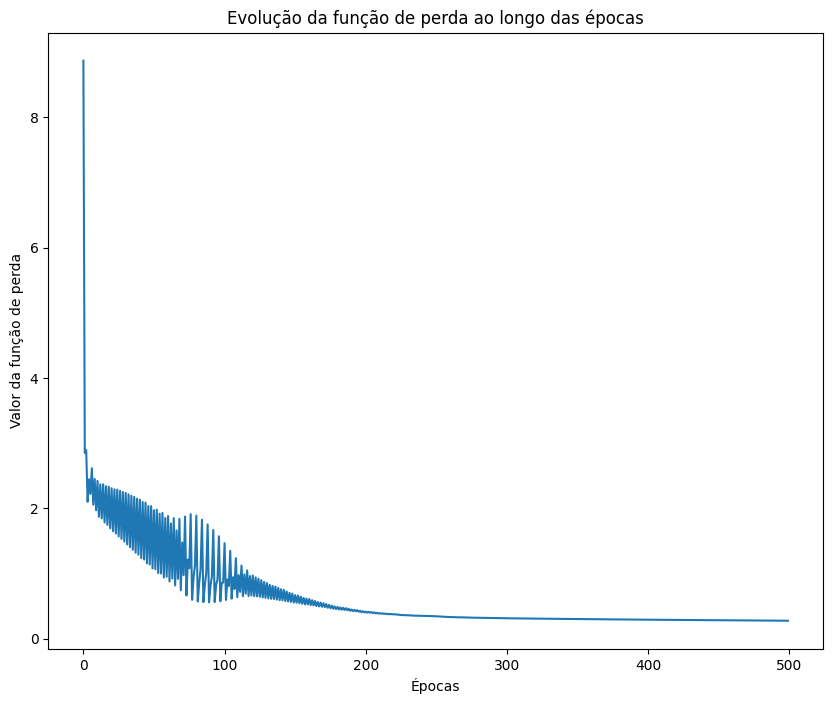

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_title('Evolução da função de perda ao longo das épocas')
ax.set_ylabel('Valor da função de perda')
ax.set_xlabel('Épocas')
ax.plot(np.asarray(loss_list))

plt.show()

## Conjunto de Exercícios 2 - Implementação de uma MLP utilizando objetos

- Aqui, iremos repetir o mesmo procedimento feito anteriormente. Porém, iremos adotar uma implementação baseada no paradigma de orientação à objetos, que será muito importante em módulos futuros para definir modelos mais complexos e manter o código organizado.

    - Abaixo teremos um código onde a classe MLP receberá quantas `features` teremos de entrada e saída, qual o tamanho das camadas ocultas, e quantas camadas ocultas iremos ter. Uma assinatura diferente para o `__init__` que você pode optar é `__init__(self, in_features, out_features, hidden_sizes, num_hidden_layers)`, onde `hidden_sizes` representa uma lista com o tamanho de cada camada oculta, definindo assim em uma só variável o número de camadas ocultas e suas dimensões. Sinta-se livre para modificar o código e experimentar com ambas opções.

Outra maneira de definir um conjunto de camadas em pytorch é o nn.ModuleList.

> https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html

Diferente do nn.Sequential, é apenas uma lista de camadas, e portanto não define uma ordem explcíta de operações. Por que então o utilizamos?

> - O ModuleList funciona de maneira similar a uma lista normal em python, e é fácil de se utilizar;
>  > Para adicionar uma nova camada, basta chamar a função .append
> - Podemos adicionar quantas camadas quisermos no ModuleList, facilitando a variação no número de camadas do modelo.
> - As camadas adicionadas ao ModuleList já tem seus parâmetros automaticamente adicionados ao modelo.

Para rodar as camadas de seu ModuleList, é necessárias chamá-las individualmente. Para isso, basta iterar pelo ModuleList com um loop for, e chamar cada uma das camadas.

In [25]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_size, num_hidden_layers):
        super().__init__()

        self.input_layer = nn.Linear(in_features, hidden_size)
        self.ReLu = nn.ReLU()
        
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.output_layer = nn.Linear(hidden_size, out_features)
        self.activation = nn.Identity()


    def forward(self, x):

        out = self.ReLu(self.input_layer(x))
        
        for layer in self.hidden_layers:
            out = layer(out)
                
        return self.activation(self.output_layer(out))

In [31]:
in_features = 30
out_features = 1

# Instancie o seu modelo aqui
model = MLP(in_features, out_features, hidden_size=64, num_hidden_layers=2)

model = model.to(device)
print(model)

MLP(
  (input_layer): Linear(in_features=30, out_features=64, bias=True)
  (ReLu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Identity()
)


- Agora iremos treinar o modelo normalmente.

In [27]:
learning_rate = 1e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Aqui iremos criar uma lista de loss para cada época
loss_list = []

# Iterando sobre as épocas
n_epochs = 500
for epoch in range(n_epochs):
    preds = model(X)
    loss = criterion(preds, y)

    # Salvando a loss da iteração atual (para plots futuros)
    loss_list.append(loss.item())

    # Antes de fazermos o backward pass, iremos zerar o gradiente de todos os tensores
    # atrelados ao otimizador utilizando a chamada de função .zero_grad() do nosso otimizador.
    # Faremos isso pois os gradientes são acumulados, sempre que chamamos .backward(), em buffers nos
    # tensores que representam os pesos dos nossos modelos, ou seja, não são sobrescritos.
    # Para mais detalhes, você pode dar uma olhada na documentação do torch.autograd.backward
    optimizer.zero_grad()

    # Realizando o backward pass, ou seja, computando os gradientes da nossa função de perda
    # com respeito aos parâmetros (pesos) do nosso modelo
    loss.backward()

    # Chamando a função .step() do nosso otimizador para realizar um "passo" na otimização.
    # Nesse caso, o "passo" será realizar o cálculo que vimos do gradiente descendente
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}: loss = {loss.item():.5f}')

Epoch 10: loss = 1.13370
Epoch 20: loss = 1.05214
Epoch 30: loss = 0.95491
Epoch 40: loss = 0.86056
Epoch 50: loss = 0.78396
Epoch 60: loss = 0.71032
Epoch 70: loss = 0.63710
Epoch 80: loss = 0.58435
Epoch 90: loss = 0.52134
Epoch 100: loss = 0.48369
Epoch 110: loss = 0.43992
Epoch 120: loss = 0.41344
Epoch 130: loss = 0.39750
Epoch 140: loss = 0.38224
Epoch 150: loss = 0.37148
Epoch 160: loss = 0.36454
Epoch 170: loss = 0.35925
Epoch 180: loss = 0.35527
Epoch 190: loss = 0.35191
Epoch 200: loss = 0.34833
Epoch 210: loss = 0.34498
Epoch 220: loss = 0.34130
Epoch 230: loss = 0.33810
Epoch 240: loss = 0.33493
Epoch 250: loss = 0.33187
Epoch 260: loss = 0.32906
Epoch 270: loss = 0.32630
Epoch 280: loss = 0.32354
Epoch 290: loss = 0.32106
Epoch 300: loss = 0.31868
Epoch 310: loss = 0.31633
Epoch 320: loss = 0.31414
Epoch 330: loss = 0.31206
Epoch 340: loss = 0.30989
Epoch 350: loss = 0.30795
Epoch 360: loss = 0.30603
Epoch 370: loss = 0.30431
Epoch 380: loss = 0.30248
Epoch 390: loss = 0.3

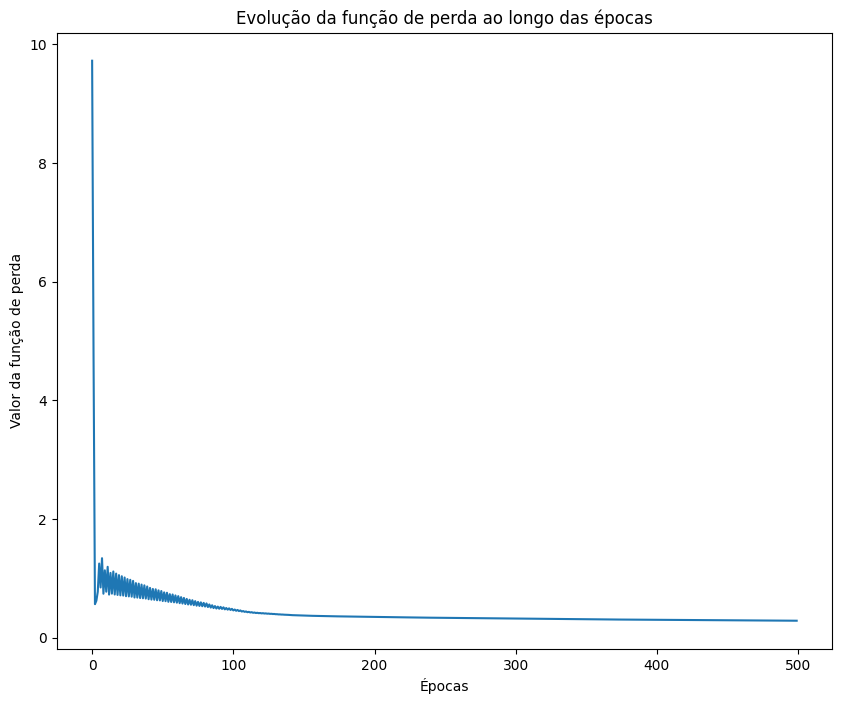

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_title('Evolução da função de perda ao longo das épocas')
ax.set_ylabel('Valor da função de perda')
ax.set_xlabel('Épocas')
ax.plot(np.asarray(loss_list))

plt.show()